In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os 
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


from extract_data import ExtractPredictionDataset
from scaler import FeaturesScaler
from dataloader import HardMagni

In [2]:
PATH = "../icra-magni-benchmark/data"  # path to preprocessed scenarios directory
SCENARIOS_USED = ["Scenario_1", "Scenario_2", "Scenario_3", "Scenario_4", "Scenario_5"]
TEST_SCENARIO = "Scenario_1"
MAPS_PATH = "../datasets/thor_magni_pub_ready/maps" # path to obstacles maps directory

In [3]:
train_scenarios = SCENARIOS_USED
train_scenarios.remove(TEST_SCENARIO)
train_scenarios

['Scenario_2', 'Scenario_3', 'Scenario_4', 'Scenario_5']

In [4]:
DATA_CONFIG = {
    "obs_len" : 8,
    "pred_len" : 12, 
    "min_speed" : 0., 
    "max_speed" : 2.5,
}

# Loading data

In [5]:
tracklet_len = DATA_CONFIG["obs_len"] + DATA_CONFIG["pred_len"]
min_speed = DATA_CONFIG["min_speed"]
max_speed = DATA_CONFIG["max_speed"]

train_tracklets = []
for train_scenario in train_scenarios:
    train_tracklets.extend(
        ExtractPredictionDataset.get_tracklets_scenario(
            path=os.path.join(PATH, train_scenario),
            tracklet_len=tracklet_len,
            min_speed=min_speed,
            max_speed=max_speed,
        )
    )

test_tracklets = ExtractPredictionDataset.get_tracklets_scenario(
    path=os.path.join(PATH, TEST_SCENARIO),
    tracklet_len=tracklet_len,
    min_speed=min_speed,
    max_speed=max_speed,
)

In [6]:
len(train_tracklets), len(test_tracklets)

(5958, 2935)

In [7]:
full_ds_scl, statistics = FeaturesScaler.scale_dataset(train_tracklets)

In [8]:
train_ds = HardMagni(
    train_tracklets,
    visuals_path=MAPS_PATH,
    obs_len=DATA_CONFIG["obs_len"],
    window_size=3.5,
    collapse_visitors=False,
)

In [9]:
train_dl = DataLoader(train_ds, 4, shuffle=True)
train_dl_i = iter(train_dl)

In [10]:
sample = next(train_dl_i)

In [11]:
SAMPLE_IDX = 3

In [12]:
obstacle_map = sample["img"][SAMPLE_IDX].permute(1,2,0).numpy()
trajectory_pixels = sample["trajectories_pixels"][SAMPLE_IDX][:, :2]

In [13]:
tracklet_origin = trajectory_pixels[DATA_CONFIG["obs_len"] - 1]
traj_transformed = (
    trajectory_pixels[:7]
    - tracklet_origin
    + np.array([train_ds.window_size, train_ds.window_size])
)

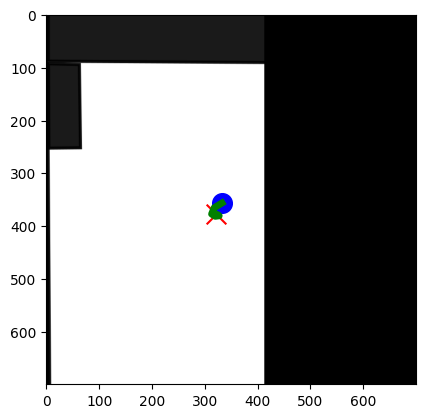

In [14]:
plt.imshow(obstacle_map);
plt.scatter(traj_transformed[0, 0], traj_transformed[0, 1], s=200, color="red", marker="x");
plt.scatter(traj_transformed[-1, 0], traj_transformed[-1, 1], s=200, color="blue");
plt.plot(traj_transformed[:, 0], traj_transformed[:, 1], linewidth=5, color="green");